In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
import plotly.express as px
from dotenv import load_dotenv
import json
from collections import defaultdict
import importlib
import warnings
warnings.filterwarnings('ignore')
import utils
importlib.reload(utils)
import os
from scipy.stats import linregress
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error


# Load observations

In [2]:
# Load datasets for observations
def load_observations(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location):
    # Define the expected column names for the final concatenated DataFrame
    TREATMENT = "Treatment"
    LOCATION = "Location"
    xls = pd.ExcelFile(file_path, engine="openpyxl")
    raw_df_BB = pd.read_excel(xls, sheet_name = BB_sheet_name)
    raw_df_Flwr = pd.read_excel(xls, sheet_name = Flwr_sheet_name)

    # Rename the Dates to Days of Year (DOY)
    doy_column_BB = [pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)]
    df_BB = raw_df_BB.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_BB.columns if utils.is_date_column(col)})

    doy_column_Flwr = [pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)]
    df_Flwr = raw_df_Flwr.rename(columns={col:pd.to_datetime(col).dayofyear for col in raw_df_Flwr.columns if utils.is_date_column(col)})

    obs_year = [pd.to_datetime(col).year for col in raw_df_BB.columns if utils.is_date_column(col)][0]


    # Apply filtering for the given cultivar & treatments
    def filter_df(df, doy_column):
        filtered_df = df[df[cultivar_col].isin([cultivar_name]) & df[treatment_col].isin([treatment_name])]
        # Rename columns
        columns_to_select = [treatment_col] + doy_column  # Ensure it's a flat list
        filtered_df = filtered_df[columns_to_select]
        filtered_df.rename(columns={treatment_col: TREATMENT}, inplace=True)
        # Add the LOCATION column to the DataFrame
        filtered_df[LOCATION] = location
        # Remove rows with any NaN values
        filtered_df = filtered_df.dropna()
        # Reset index 
        filtered_df.reset_index(drop=True)
        return filtered_df
    filtered_df_BB = filter_df(df_BB,doy_column_BB)
    # print(file_path,'/',Flwr_sheet_name)
    # print(df_Flwr.head(1))
    filtered_df_Flwr = filter_df(df_Flwr,doy_column_Flwr)

    BB_percent = False

    PBB, BB, BudBurstDOY, max_observed_buds = utils.BB_specifications(location,filtered_df_BB[doy_column_BB],BB_percent)
    maxBBsequence = np.empty(len(doy_column_BB))*np.nan
    maxBBsequence[-1] = np.max(BB)

    # Corresponding stage name (StartFlowering) to get the max BBP 
    MaxBBstageSequence = [np.nan for i in range(len(doy_column_BB))]
    MaxBBstageSequence[-1] = 'StartFlowering'
    # Generate the observations Excel file
    
    excel_observ_BB = pd.DataFrame(data={
    'SimulationName': f'{BB_sheet_name}{filtered_df_BB[TREATMENT].iloc[0].replace(" ", "")}', 
                                        'Clock.Today': [col for col in raw_df_BB.columns if utils.is_date_column(col)],
                                        'Clock.Today.Year': obs_year,
                                        'DOY': doy_column_BB, 
                                        LOCATION: filtered_df_BB[LOCATION].iloc[0], 
                                        TREATMENT: filtered_df_BB[TREATMENT].iloc[0],
                                        'KiwiFruit.Phenology.BrokenBuds': BB,
                                        'KiwiFruit.Phenology.MaxBB': maxBBsequence,
                                        # 'KiwiFruit.Phenology.ProportionBB': PBB,
                                        'KiwiFruit.Phenology.BudBurstDOY': BudBurstDOY,
                                        'KiwiFruit.Phenology.CurrentStageName': MaxBBstageSequence})
    
    FlwrDOY, Flowers = utils.Flwr_specifications(np.max(BB),filtered_df_Flwr[doy_column_Flwr])
    maxFlwrsequence = np.empty(len(doy_column_Flwr))*np.nan
    maxFlwrsequence[-1] = FlwrDOY

    # Corresponding stage name (StartFlowering) to get the max BBP 
    MaxFlwrstageSequence = [np.nan for i in range(len(doy_column_Flwr))]
    MaxFlwrstageSequence[-1] = 'StartFlowering'
    excel_observ_Flwr = pd.DataFrame(data={
    'SimulationName': f'{BB_sheet_name}{filtered_df_BB[TREATMENT].iloc[0].replace(" ", "")}',  # Use same BB sheet name to be able to put in same apsim simulation
                                        'Clock.Today': [col for col in raw_df_Flwr.columns if utils.is_date_column(col)],
                                        'Clock.Today.Year': obs_year,
                                        'DOY': doy_column_Flwr, 
                                        LOCATION: filtered_df_Flwr[LOCATION].iloc[0], 
                                        TREATMENT: filtered_df_Flwr[TREATMENT].iloc[0],
                                        'KiwiFruit.Phenology.Flowers': Flowers,
                                        'KiwiFruit.Phenology.FloweringDOY': FlwrDOY,
                                        'KiwiFruit.Phenology.CurrentStageName': MaxFlwrstageSequence})

    return obs_year, PBB, BB, BudBurstDOY, excel_observ_BB, FlwrDOY, excel_observ_Flwr
    


# WangEngel & GDH & Chill models

In [86]:
def Chill(Tc, T):
    if T>=0 and T <= Tc:
        return (((4*T)/(Tc**2))*(Tc-T))
    else:
        return 0

def HrsBelowBase(Tc, MeanT):
    if MeanT<0: chill_unit = 0 
    if MeanT >= 0 and MeanT <= Tc: chill_unit = -MeanT + Tc 
    if MeanT > Tc: chill_unit = 0
    return chill_unit

def Wangengel(MinTemp,OptTemp,MaxTemp,RefTemp,T):
    RelEff = 0.0
    RelEffRefTemp = 1.0
    p = 0.0

    if MinTemp < T < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEff = (2 * (T - MinTemp) ** p * (OptTemp - MinTemp) ** p - (T - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    if MinTemp < RefTemp < MaxTemp:
        p = math.log(2.0) / math.log((MaxTemp - MinTemp) / (OptTemp - MinTemp))
        RelEffRefTemp = (2 * (RefTemp - MinTemp) ** p * (OptTemp - MinTemp) ** p - (RefTemp - MinTemp) ** (2 * p)) / (OptTemp - MinTemp) ** (2 * p)

    return round(float(RelEff / RelEffRefTemp),3)

def GDH(Tb,Tu,Tc,T):
    if (T > Tb) and (T <= Tu):
        return float(0.5 * (1 + np.cos(np.pi + np.pi * ((T - Tb) / (Tu - Tb)))))
    elif (T > Tu) and (T <= Tc):
        return float((1 + np.cos(0.5*np.pi + 0.5*np.pi * ((T - Tu) / (Tc - Tu)))))
    else:
        return 0
    
def HallChillModel(T, S, T1, T2, T_hi, T_lo, c1, T_base, r, k):    
    # T1 = 2.45
    # T2 = 21
    # T_hi = 16.45
    # T_lo = -40.82
    # c1 = 0.000411

    if T < T1 : chill_unit = 0
    if (T >= T1) and (T <= T2): chill_unit = c1 * (T_hi - T) * (T - T_lo)
    if (T > T2): chill_unit =  c1 * (T_hi - T2) * (T2 - T_lo)


    # T_base = 2
    # r = 0.0002924
    if T < T_base: heat_unit = 0
    if T >= T_base: heat_unit = r * (T - T_base)

    # k = 4
    Weight = ((1+np.exp(-.5*k))/(1+np.exp(-k*(S-.5)))) * ((1-np.exp(-k*S))/(1-np.exp(-k)))
    
    delta_S = (1- Weight) * chill_unit +  Weight * heat_unit

    return delta_S

def estimate_leaf_area_per_cane(temps, n_broken_buds, max_leaf_area_per_shoot, Tmin, Topt, Tmax, Tref):
    """
    Estimate leaf area per cane using a beta temperature response.

    Parameters:
    - temps: hourly temperatures 
    - n_broken_buds: number of broken buds (shoots) per cane
    - max_leaf_area_per_shoot: max m2 leaf per shoot (0.04-0.06 for Hayward)
    
    Returns:
    - leaf_area_per_cane (m2)
    """
    # Calculate hourly growth response
    response = np.array([Wangengel(Tmin, Topt, Tmax, Tref, T) for T in temps])
    
    # Integrate relative expansion (GDH) over time (hourly)
    # Output is normalized to 0–1 scale
    gdh_relative = np.cumsum(response) / np.sum(response)  
    
    # Leaf area per cane = shoots × leaf per shoot × final expansion
    leaf_area_per_cane = n_broken_buds * max_leaf_area_per_shoot * gdh_relative

    
    return leaf_area_per_cane

def logistic_fit(weather, x_days, y_buds):
    # Compute GDH for each hour
    weather['GDH'] = np.array([Wangengel(utils.base_model_config()['MinTemp_flwr'], utils.base_model_config()['OptTemp_flwr'], utils.base_model_config()['MaxTemp_flwr'], utils.base_model_config()['RefTemp_flwr'], T) for T in weather['temp']])

    # Cumulative GDH
    weather['cumulative_GDH'] = weather['GDH'].cumsum()

    doy_to_gdh = {}
    for doy in x_days:
        match = weather[weather['doy'] == doy]
        if not match.empty:
            # Take last GDH value of that day
            doy_to_gdh[doy] = match['cumulative_GDH'].iloc[-1]

    # Map x DOY values to GDH
    x_gdh = [doy_to_gdh[d] for d in x_days]


    # A: final value
    # k: growth rate
    # x0: midpoint

    def logistic(x, A, k, x0):
        return A / (1 + np.exp(-k * (x - x0)))

    # Fit the curve
    params, _ = curve_fit(logistic, x_gdh, y_buds, p0=[np.max(y_buds), 0.3, np.mean(x_gdh)], bounds=(0, np.inf), method='trf', max_nfev=10000 )

    # Predict values
    y_fit = logistic(np.array(x_gdh), *params)
    
    return x_gdh, y_fit, params


# Chill/Heat Accumulation

In [87]:
# Chill & heat accumulation
def chill_heat_accumulation(model_config, buds_targets, predicted_endo_release_doy, predicted_budbreak_doy, predicted_flowering_doy, weather_since_start_doy, BB_sheet_name, Flwr_sheet_name, treatment_name):
    for bud_position,target in buds_targets.items():
        chill_requirement = target['chill']
        bb_heat_requirement = target['bbHeat']
        flwr_heat_requirement = target['FlwrHeat']
        
        # Chill model parameter
        chillVal = 0
        for idx_endodormancy_release, temp in enumerate(weather_since_start_doy['temp']):
            chillVal += Chill(utils.base_model_config()['Tc_chill'], temp)
            if chillVal >= chill_requirement:
                predicted_endo_release_doy[BB_sheet_name+treatment_name][bud_position] = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release])  # Get the date at this index
                break
        # wangengel model parameters
        # from the date of endodormancy release, start accumulating heat
        heatVal = 0
        predicted_budbreak_doy[BB_sheet_name+treatment_name][bud_position] = 365 # Default value if heat target not reached
        for idx_bb, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+1::]):
            heatVal += Wangengel(model_config["MinTemp_BB"], model_config["OptTemp_BB"],model_config["MaxTemp_BB"], model_config["RefTemp_BB"],temp)
            if heatVal >= bb_heat_requirement:
                predicted_budbreak_doy[BB_sheet_name+treatment_name][bud_position] = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release+idx_bb+1]) 
                break
        
        # from the date of budbreak, start accumulating heat
        heatVal = 0
        # weather_since_chill_target = weather_since_start_doy[weather_since_start_doy['doy']>=predicted_endo_release_doy[BB_sheet_name+treatment_name][bud_position]]
        for idx_flwr, temp in enumerate(weather_since_start_doy['temp'][idx_endodormancy_release+idx_bb+1::]):
            heatVal += Wangengel(model_config["MinTemp_flwr"], model_config["OptTemp_flwr"],model_config["MaxTemp_flwr"],model_config["RefTemp_flwr"],temp)
            if heatVal >= flwr_heat_requirement:
                predicted_flowering_doy[Flwr_sheet_name+treatment_name][bud_position] = int(weather_since_start_doy['doy'].iloc[idx_endodormancy_release+idx_bb+idx_flwr+2]) 
                # print(pd.to_datetime(predicted_budbreak_doy[BB_sheet_name+treatment_name][bud_position], unit="D", origin='2020'))
                break
        

    return predicted_endo_release_doy, predicted_budbreak_doy, predicted_flowering_doy


In [88]:
with open("config_MultiDataFiles_BBFlwr.json", "r") as file:
    config = json.load(file)

def run(model_config):
    start_doy = pd.to_datetime(model_config["StartDay"]).dayofyear


    buds_targets = {1:{'chill':model_config["ChillRequirement"], 'bbHeat':model_config["HeatRequirement"], 'FlwrHeat':model_config["FlwrHeatRequirement"]}}

    predicted_endo_release_doy = defaultdict(lambda: dict())
    predicted_budbreak_doy = defaultdict(lambda: dict())
    observed_budbreak_doy = defaultdict(lambda: dict())
    predicted_flowering_doy = defaultdict(lambda: dict())
    observed_flowering_doy = defaultdict(lambda: dict())
    observed_BB = defaultdict(lambda: dict())
    excel_observs_BB = []
    excel_observs_Flwr = []
    output_excel = 'ObservAll.xlsx'

    # Load environment variables
    load_dotenv()
    FOLDER_PATH = os.getenv('FOLDER_PATH')
    for file_name, file_info in config.items():
            file_path = os.path.join(FOLDER_PATH, file_name)
            # Process each sheet
            for sheet_info in file_info['sheets']:
                # Extract sheet names, cultivars, and treatments
                BB_sheet_name = sheet_info['BB_sheet_name']
                Flwr_sheet_name = sheet_info['Flwr_sheet_name']
                location = sheet_info['location']
                # max_observed_buds = sheet_info['max_observed_buds']
                cultivar_col, cultivar_name = list(sheet_info['cultivar'].items())[0]
                treatment_col, treatment_name = list(sheet_info['treatments'].items())[0]

                # Load and calculate the observed budburst doy
                obs_year, PBB, BB, BudBurstDOY, excel_observ_BB, Flwr_DOY, excel_observ_Flwr = load_observations(file_path,BB_sheet_name, Flwr_sheet_name, cultivar_col,cultivar_name,treatment_col,treatment_name,location)
                observed_budbreak_doy[BB_sheet_name+treatment_name][1] = BudBurstDOY
                observed_flowering_doy[Flwr_sheet_name+treatment_name][1] = Flwr_DOY
                observed_BB[BB_sheet_name+treatment_name][1] = BB
                
 
                # Load the "Hourly" weather data
                weather_path = sheet_info['weather_path']
                weather_data = pd.read_csv(weather_path)
                # Slicing the weather data to the dates within the observation year
                weather_data['Date'] = pd.to_datetime(weather_data['Date'], errors='coerce')
                weather_data = weather_data[
                    (weather_data['Date'] >= pd.to_datetime(f'1/1/{obs_year}')) &
                    (weather_data['Date'] <= pd.to_datetime(f'20/05/{obs_year+1}'))]     # Defoliation next year
                # Renaming the columns and add doy column         
                weather_data = weather_data[['Date', 'Time', 'Air Temp. (°C)']].rename(columns={'Date': 'date', 'Time':'Time', 'Air Temp. (°C)':'temp'}, inplace=False)
                weather_data.insert(1, 'doy', [d.dayofyear for d in pd.to_datetime(weather_data['date'], format="mixed")])
                # Interpolate missing values
                # Convert '-' to NaN
                weather_data['temp'].replace('-', np.nan, inplace=True)
                weather_data['temp']=weather_data['temp'].apply(pd.to_numeric, errors='coerce')

                # Interpolate missing values
                if weather_data['temp'].isna().any():
                    if model_config["InterpolationMethod"] == 'linear':
                        weather_data['temp'].interpolate(method='linear', inplace=True)
                    elif model_config["InterpolationMethod"] == 'seasonal':
                        # Compute seasonal average of hourly temperatures
                        weather_data = utils.seasonal_ave_fillna(weather_data)
                    elif model_config["InterpolationMethod"] == 'longtermaverage':
                        long_term_ave = weather_data['temp'].mean()
                        weather_data['temp'].fillna(long_term_ave, inplace=True)
                    # elif model_config["InterpolationMethod"] == 'samedaycalendar':
                    #     weather_data = utils.samedaycalendar_fillna(weather_data)
                    

                weather_since_start_doy = weather_data[weather_data['doy']>=start_doy].reset_index(drop=True)  

                # Predict the endodormancy release doy and budbreak doy
                predicted_endo_release_doy, predicted_budbreak_doy, predicted_flowering_doy = chill_heat_accumulation(model_config, buds_targets, predicted_endo_release_doy, predicted_budbreak_doy, predicted_flowering_doy, weather_since_start_doy, BB_sheet_name, Flwr_sheet_name, treatment_name)

                # Bud breaking trend

                x_fit, y_fit, params = logistic_fit(weather_since_start_doy, excel_observ_BB['DOY'], BB)
                plt.figure()
                plt.plot(x_fit, BB)
                plt.plot(x_fit, y_fit, 'k--')
                plt.title(f'A: {round(params[0],1)}, K: {round(params[1],1)}, xo: {round(params[2],1)}')
                plt.show()

                # Predict Leaf Area:
                n_broken_buds = BB[-1]
                BB_doy = predicted_budbreak_doy[BB_sheet_name+treatment_name][1]
                BB_date = pd.to_datetime(f"{obs_year}-{BB_doy}", format="%Y-%j")
                weather_since_BB_doy = weather_data[weather_data['date']>= BB_date].reset_index(drop=True)
                leaf_area_per_cane = estimate_leaf_area_per_cane(weather_since_BB_doy['temp'], n_broken_buds, max_leaf_area_per_shoot=0.05, Tmin=model_config['MinTemp_flwr'], Topt=model_config['OptTemp_flwr'], Tmax=model_config['MaxTemp_flwr'], Tref=model_config['RefTemp_flwr'])
                # plot leaf_area_per_cane
                start_date = pd.to_datetime(f"{obs_year}-{BB_doy}", format="%Y-%j")
                end_date = pd.to_datetime(f'21/05/{obs_year+1}')
                # Generate hourly datetime index
                x_values = pd.date_range(start=start_date, end=end_date, freq='H')[:-1]  # remove last hour if not needed
                # plt.figure(figsize=(12, 5))
                # plt.plot(leaf_area_per_cane, 'r')
                # plt.xticks(pd.date_range(start=start_date, end=end_date, freq='10D'), rotation=45, fontsize=7)
                # plt.title(f'{location}  {obs_year}')
                # plt.grid()
                # plt.show()


                excel_observs_BB.append(excel_observ_BB)
                excel_observs_Flwr.append(excel_observ_Flwr)

    excel_observs_BB_df = pd.concat(excel_observs_BB, ignore_index=True, sort=False)
    excel_observs_Flwr_df = pd.concat(excel_observs_Flwr, ignore_index=True, sort=False)

    with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
        excel_observs_BB_df.to_excel(writer, sheet_name='BB', index=False)
        excel_observs_Flwr_df.to_excel(writer, sheet_name='Flwr', index=False)

    # Calculate stats for budbreak
    observed_all_bb = []
    predicted_all_bb = []
    for (trtmnt1,bb1),(trtmnt2,bb2) in zip(predicted_budbreak_doy.items(), observed_budbreak_doy.items()):
        predicted_all_bb.append(list(bb1.values())[0])
        observed_all_bb.append(list(bb2.values())[0])
    stats_bb = utils.calculate_fit_stats(observed_all_bb, predicted_all_bb)
    # Fit linear regression
    observed_all_bb = np.array(observed_all_bb)
    predicted_all_bb = np.array(predicted_all_bb)
    slope, intercept, _, _, _ = linregress(observed_all_bb, predicted_all_bb)
    regression_line_bb = slope * observed_all_bb + intercept

    # Calculate stats for flowering
    observed_all_flwr = []
    predicted_all_flwr = []
    for (trtmnt1,bb1),(trtmnt2,bb2) in zip(predicted_flowering_doy.items(), observed_flowering_doy.items()):
        predicted_all_flwr.append(list(bb1.values())[0])
        observed_all_flwr.append(list(bb2.values())[0])
    stats_flwr = utils.calculate_fit_stats(observed_all_flwr, predicted_all_flwr)
    # Fit linear regression
    observed_all_flwr = np.array(observed_all_flwr)
    predicted_all_flwr = np.array(predicted_all_flwr)
    slope, intercept, _, _, _ = linregress(observed_all_flwr, predicted_all_flwr)
    regression_line_flwr = slope * observed_all_flwr + intercept

    
    return weather_since_BB_doy, observed_BB, predicted_budbreak_doy, observed_budbreak_doy, stats_bb, (observed_all_bb,regression_line_bb), predicted_flowering_doy, observed_flowering_doy, stats_flwr
            

In [89]:
def observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, stats, appearance, regression_xy=False):
    all_bb_days = []
    observed_all = []; predicted_all = []
    fig = go.Figure()
    for (trtmnt1,bb1),(trtmnt2,bb2) in zip(predicted_budbreak_doy.items(), observed_budbreak_doy.items()):
        predicted_bb= list(bb1.values())[0]
        observed_bb = list(bb2.values())[0]
        predicted_all.append(list(bb1.values())[0])
        observed_all.append(list(bb2.values())[0])
        all_bb_days.append(observed_bb); all_bb_days.append(predicted_bb) # to collect all the observation days in all treatments for x-axis doy
        fig.add_trace(go.Scatter(x=[observed_bb], y=[predicted_bb], mode='markers', marker=dict(size=15), name=trtmnt2))

    # Add 1:1 dashed line
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=[min(all_bb_days), max(all_bb_days)], mode='lines', line=dict(color="white", dash="dash"), name="1:1 Line")) 

    # Calculate std of observations to compare with MAE
    obs_std = round(np.std(observed_all),2)
    # ±MAE bands
    upper_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(stats['MAE'])   
    lower_line_mae = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(stats['MAE'])  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='+MAE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_mae, mode='lines', line=dict(color="grey", dash="dot"), name='-MAE'))  
    # RMSE bands: If RMSE bands are much wider than MAE bands, it means there are large outliers affecting the model's performance.
    upper_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) + np.array(stats['RMSE'])   
    lower_line_rmse = np.array([min(all_bb_days), max(all_bb_days)]) - np.array(stats['RMSE'])  
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=upper_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='+RMSE'))
    fig.add_trace(go.Scatter(x=[min(all_bb_days), max(all_bb_days)], y=lower_line_rmse, mode='lines', line=dict(color="yellow", dash="dot"), name='-RMSE'))  

    # Plot regression line
    if regression_xy is not False:
        fig.add_trace(go.Scatter(x=regression_xy[0], y=regression_xy[1], mode='lines', line=dict(color="white", dash="solid"), name=f"Regression"))

    # Update layout
    fig.update_layout(
        title= f"{appearance} (MAE = {stats['MAE']}, RMSE = {stats['RMSE']}, ObsSTD = {obs_std})",
        xaxis_title=f"Observed {appearance} DOY",
        yaxis_title=f"Predicted {appearance} DOY",
        template="plotly_dark")
    fig.show()


# Test parameter values

In [90]:
class Test:
    def __init__(self, config_param_name):
        self.config_param_name = config_param_name

    def _test_parameter(self, list_values_to_test):
        self.list_values_to_test = list_values_to_test
        # Load default configuration
        self.model_config = utils.base_model_config()

        min_mae = np.inf # find the value with the minimum mae
        min_rmse = np.inf
        self.opt_param = 0
        for t in self.list_values_to_test:
            self.model_config[self.config_param_name] = t
            _, _, _, _, stats_bb, _, _, _, _ = run(self.model_config)
            print('T = ',t,':')
            print(stats_bb,'\n')
            if stats_bb["MAE"] < min_mae:
                self.opt_param = t
                min_mae = stats_bb["MAE"]
                min_rmse = stats_bb['RMSE']
            elif stats_bb["MAE"] == min_mae and stats_bb["RMSE"] < min_rmse: # in case the MAE is the same, check for minimum RMSE
                    self.opt_param = t
                    min_rmse = stats_bb["RMSE"]
                # Pick the one with lowest error to plot
        print('Best value: ', self.opt_param)
        return self.opt_param

    def _best_value_plot(self, opt_param):
        self.model_config[self.config_param_name] = opt_param
        weather_since_BB_doy, observed_BB, predicted_budbreak_doy, observed_budbreak_doy, stats_bb,  regression_xy_bb, predicted_flowering_doy, observed_flowering_doy, stats_flwr  = run(self.model_config)
        observ_predict_plot(predicted_budbreak_doy, observed_budbreak_doy, stats_bb, "BudBurst", regression_xy=False)
        observ_predict_plot(predicted_flowering_doy, observed_flowering_doy, stats_flwr, "Flowering", regression_xy=False)
        return weather_since_BB_doy, observed_BB, predicted_budbreak_doy, observed_budbreak_doy, predicted_flowering_doy, observed_flowering_doy 

    def _apsim_compare(self, apsim_bb_predictions, predicted_budbreak_doy, observed_budbreak_doy):

        observed_all = []; predicted_all = []
        fig = go.Figure()
        for (trtmnt1,bb1),(trtmnt2,bb2) in zip(predicted_budbreak_doy.items(), observed_budbreak_doy.items()):
            predicted_all.append(list(bb1.values())[0])
            observed_all.append(list(bb2.values())[0])

        # Calculate MAE
        mae_real_hourly = mean_absolute_error(observed_all, predicted_all)
        mae_interpolated_hourly = mean_absolute_error(observed_all, apsim_bb_predictions)

        # Calculate the difference between apsim predictions and Python
        diff = np.sum([np.abs(list(v.values())[0] - a) for v,a in zip(predicted_budbreak_doy.values(),apsim_bb_predictions)])


        apsim_python_comparison = pd.DataFrame({'Observed': observed_all, 'APSIM': apsim_bb_predictions, 'Python': predicted_all})

        fig = px.scatter(apsim_python_comparison, x="Observed", y=["Python","APSIM"])
        # Update legend labels
        fig.for_each_trace(lambda t: t.update(name=f"{t.name} (MAE={mae_real_hourly:.2f})") if t.name == "Python" else t.update(name=f"{t.name} (MAE={mae_interpolated_hourly:.2f})"))

        # Add the 1:1 line for comparison
        fig.add_trace(go.Scatter(x=[min(observed_all), max(observed_all)], y=[min(observed_all), max(observed_all)], mode='lines', line=dict(color="black", dash="dash"), name="1:1"))  # Dashed black line

        fig.update_traces(marker=dict(size=12,
                                    line=dict(width=2,
                                    color='DarkSlateGrey')),
                                    selector=dict(mode='markers'))
        fig.update_layout(
            title=f"APSIM & Python Predictions (interpolated hourly temp. vs real hourly temp.)  Diff = {diff}",
            xaxis_title="Observed BudBurst DOY",
            yaxis_title="Predicted BudBurst DOY")
        fig.update_xaxes(
                    tickmode="array", 
                    tickvals=np.arange(np.min(observed_all),np.max(observed_all),1),  # Use all available dates as ticks
                    tickangle=45,
                    tickfont=dict(size=12))  # Rotate for better visibility

        fig.show()
        

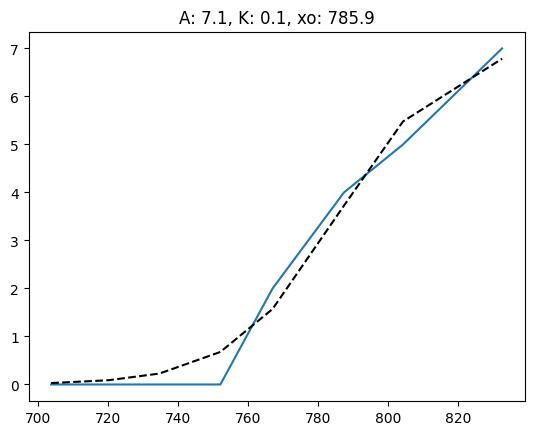

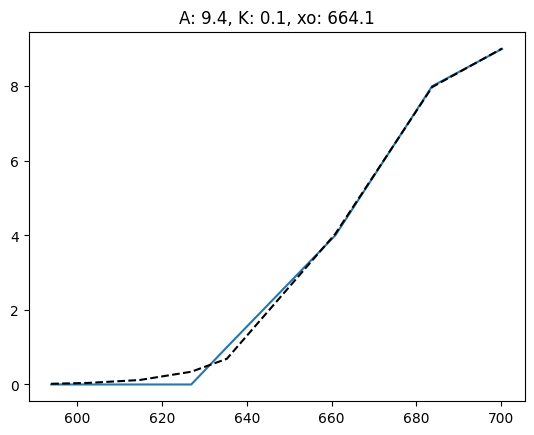

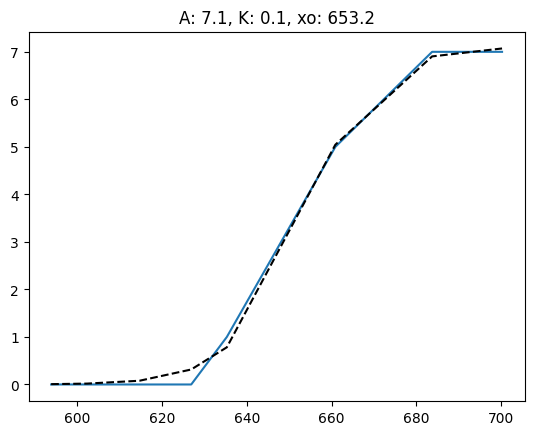

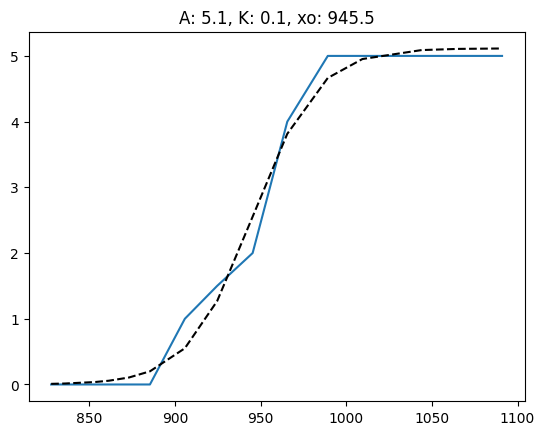

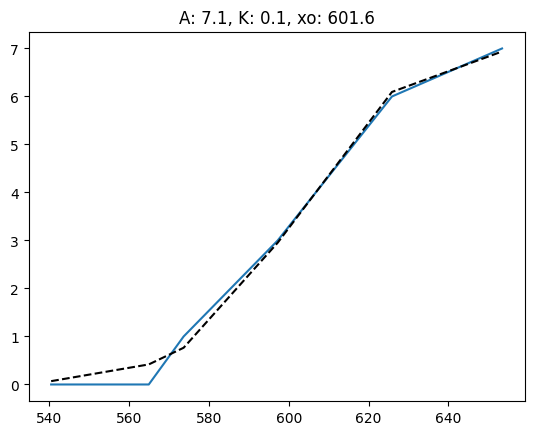

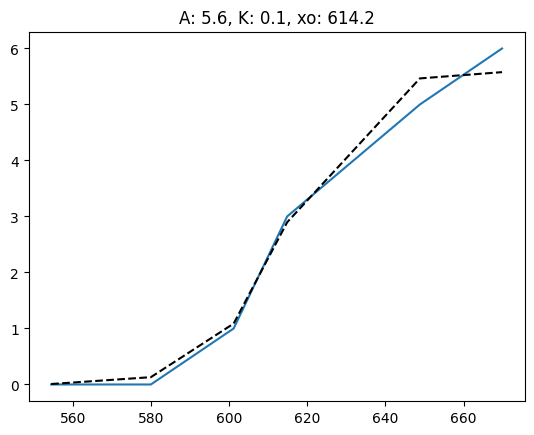

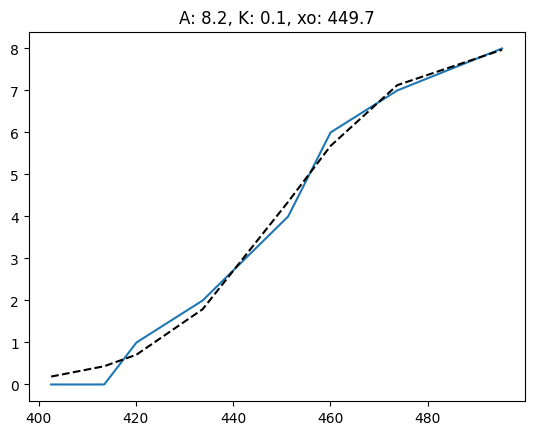

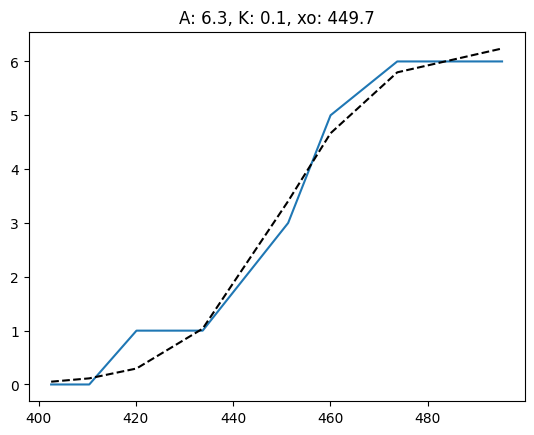

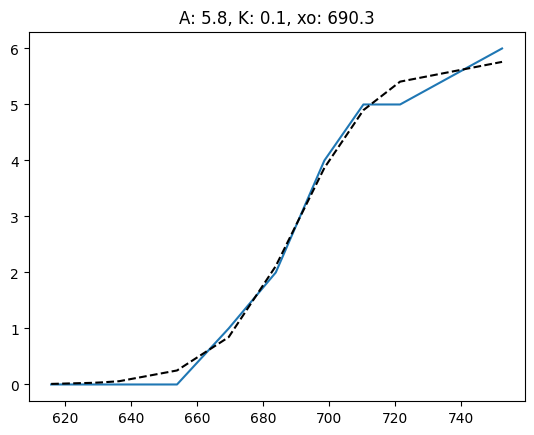

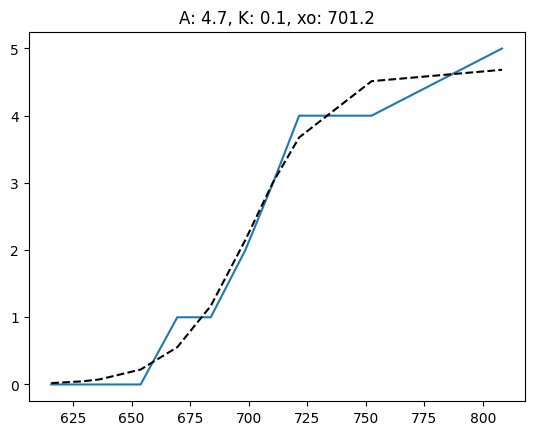

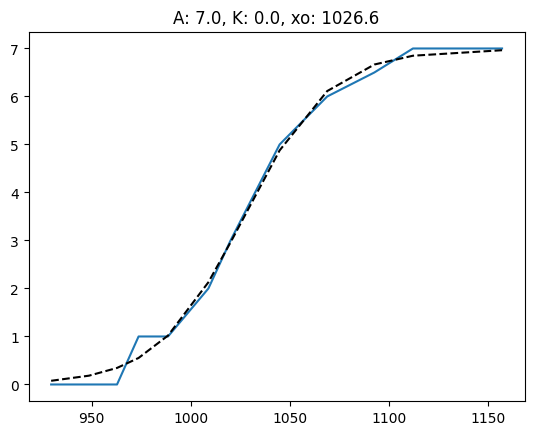

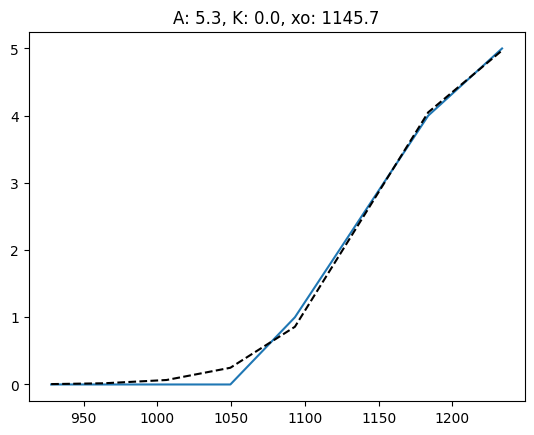

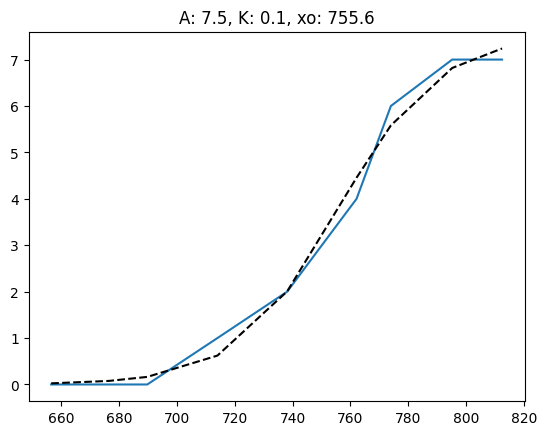

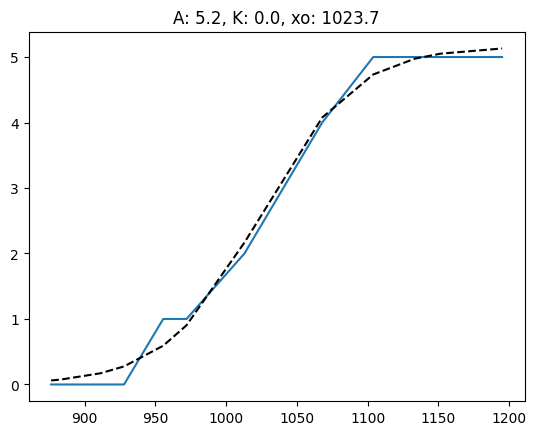

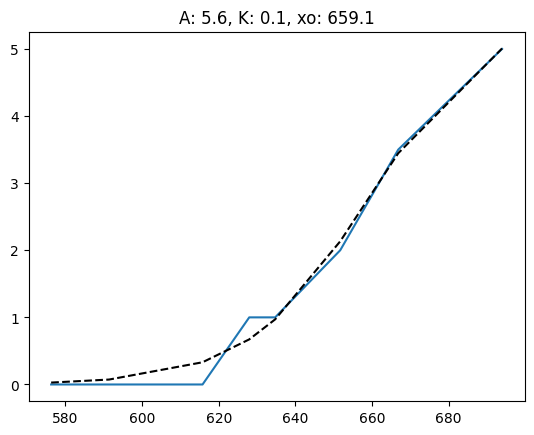

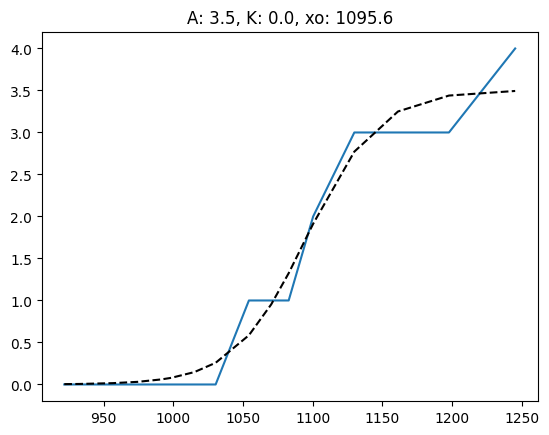

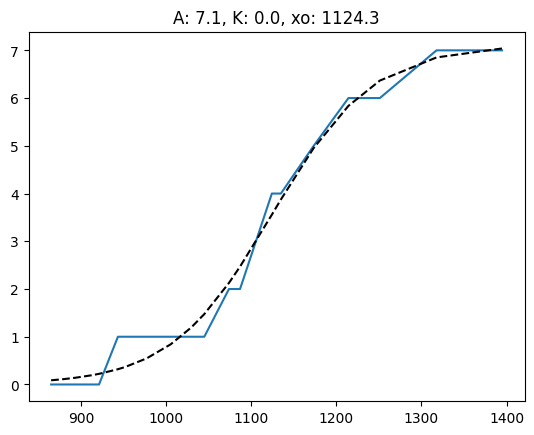

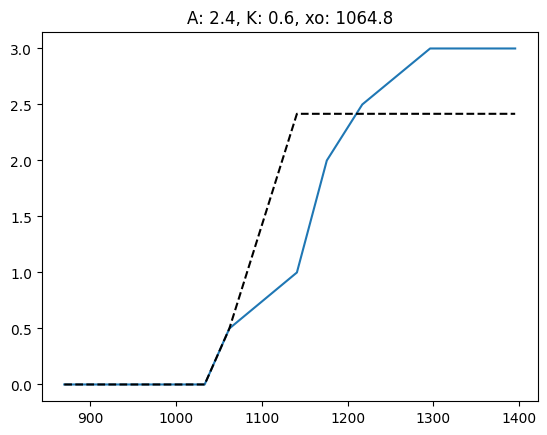

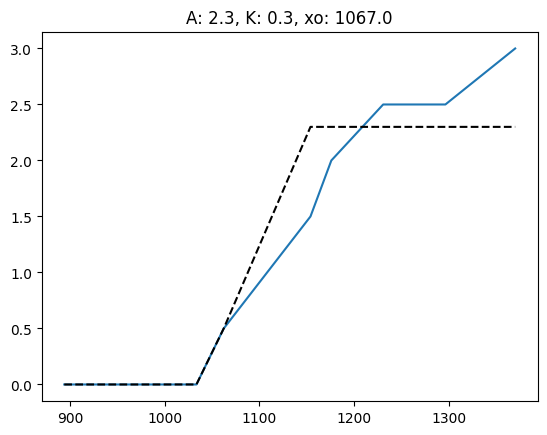

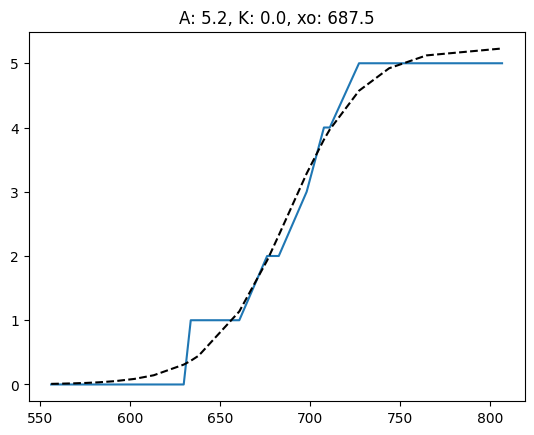

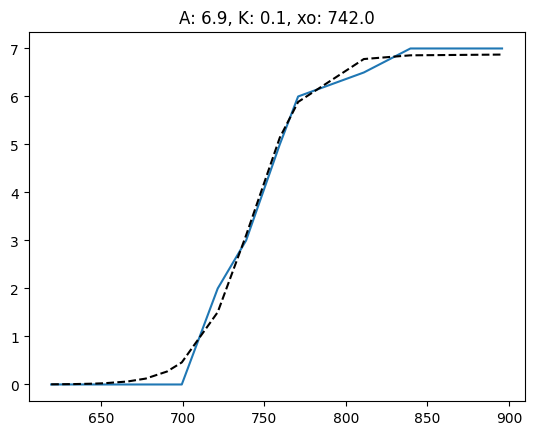

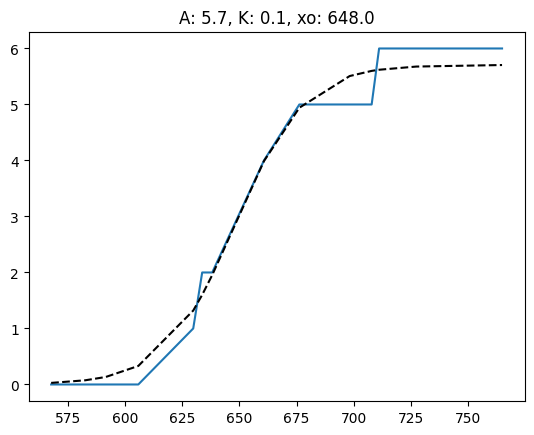

T =  8 :
{'RMSE': 4.4, 'MAE': 3.5, 'R2': 0.81, 'NRMSE': 0.11, 'MSD': 19.32} 

Best value:  8


In [91]:
importlib.reload(utils)

# Example test:
# config_param_name = "StartDayTP"

# start_date = "2000-01-01"
# end_date = "2000-03-21"
# interval = "5D"  # 5-day intervals

# config_param_variations = pd.date_range(start=start_date, end=end_date, freq=interval).strftime('%Y-%m-%d').tolist()


config_param_name = 'Tb_GDH'
config_param_variations = [8]

TestObject = Test(config_param_name)
best_val = TestObject._test_parameter(config_param_variations)
# predicted_budbreak_doy, observed_budbreak_doy = TestObject._best_value_plot(best_val)

In [ ]:
weather_since_BB_doy, observed_BB, predicted_budbreak_doy, observed_budbreak_doy, predicted_flowering_doy, observed_flowering_doy  = TestObject._best_value_plot(best_val)